In [1]:
# Imports here
import torch
from torchvision import models
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import collections
import os
import scipy.io
import shutil
import random
import json
import urllib.request
import tarfile
from tqdm import tqdm
from PIL import Image

In [ ]:
"""url = 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz' 
file_name = 'flower_data.tar.gz'
urllib.request.urlretrieve(url, file_name)
print(f"{file_name} downloaded.")

with tarfile.open(file_name, 'r:gz') as tar:
    tar.extractall(path='C:/Users/DELL/Desktop/Savana/Projects/image-classifier/flowers')
    print("Files extracted.")

os.remove(file_name)
print(f"{file_name} removed.")"""

In [3]:
data_dir = 'C:/Users/DELL/Desktop/Savana/Projects/image-classifier/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [7]:
with open('C:/Users/DELL/Desktop/Savana/Projects/image-classifier/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
categories_int_keyed = {int(key): value for key, value in cat_to_name.items()}
sorted_categories = collections.OrderedDict(sorted(categories_int_keyed.items()))

In [9]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad=False

model.classifier = nn.Sequential(nn.Linear(25088, 512),
                                nn.ReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(512, 102),
                                nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

model.to(device)
epochs = 5
train_losses, valid_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}")

    for inputs, labels in train_loader_tqdm:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=running_loss / len(train_loader))

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    valid_loader_tqdm = tqdm(valid_loader, total=len(valid_loader), desc="Validating")

    with torch.no_grad():
        for inputs, labels in valid_loader_tqdm:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loader_tqdm.set_postfix(loss=running_loss / len(valid_loader))

    valid_loss = running_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{epochs}], '
        f'Train Loss: {train_loss:.4f}, '
        f'Valid Loss: {valid_loss:.4f}, '
        f'Accuracy: {accuracy:.2f}%')

C:\Users\DELL\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validating: 100%|██████████| 13/13 [04:43<00:00, 21.80s/it, loss=0.75] 


Epoch [1/5], Train Loss: 2.2075, Valid Loss: 0.7505, Accuracy: 79.46%


Validating: 100%|██████████| 13/13 [04:44<00:00, 21.91s/it, loss=0.504]


Epoch [2/5], Train Loss: 1.0058, Valid Loss: 0.5044, Accuracy: 84.72%


Validating: 100%|██████████| 13/13 [04:43<00:00, 21.81s/it, loss=0.414]


Epoch [3/5], Train Loss: 0.8066, Valid Loss: 0.4141, Accuracy: 88.75%


Validating: 100%|██████████| 13/13 [04:45<00:00, 21.97s/it, loss=0.435]


Epoch [4/5], Train Loss: 0.7474, Valid Loss: 0.4354, Accuracy: 88.63%


Validating: 100%|██████████| 13/13 [04:42<00:00, 21.75s/it, loss=0.399]

Epoch [5/5], Train Loss: 0.6814, Valid Loss: 0.3985, Accuracy: 90.10%


In [10]:
# TODO: Do validation on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        preds = model(inputs)
        loss = criterion(preds, labels)
        test_loss+=loss.item()
        _, predicted = preds.max(1)
        total+=labels.size(0)
        correct += (predicted == labels).sum().item()
        
test_loss /= len(test_loader)
test_accuracy = 100*correct/total

print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.462, Test Accuracy: 88.16%


In [11]:
# TODO: Save the checkpoint
model.class_to_idx = train_data.class_to_idx

checkpoint = {
    'architecture': 'vgg16',
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': train_data.class_to_idx,
    'classifier': model.classifier,
    'epochs': epochs, # Use the existing 'epochs' variable instead of the undefined 'num_epochs'
    'learning_rate': 0.001
}

torch.save(checkpoint, 'C:/Users/DELL/Desktop/Savana/Projects/image-classifier/vgg_checkpoint.pth')

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
checkpoint = torch.load('vgg_checkpoint.pth')

model = models.vgg16(pretrained=True) # Corrected the typo 'pretained' to 'pretrained'
model.classifier = checkpoint['classifier']
model.load_state_dict(checkpoint['model_state_dict'])
model.class_to_idx = checkpoint['class_to_idx']
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = checkpoint['epochs']

print(model)
print(optimizer)
print(epochs)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11252\2473164541.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('vgg_checkpoint.pth')


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # TODO: Process a PIL image for use in a PyTorch model
    pil_img = Image.open(image)
    edit_img = transforms.Compose([transforms.Resize(226),
                                  transforms.RandomCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224,0.225])])
    img_tensor = edit_img(pil_img)
    processed = np.array(img_tensor)
    processed = processed.transpose((0,2,1))
    return processed
    
image_path = test_dir+'/1/image_06743.jpg'
img = process_image(image_path)
print(img.shape)

(3, 224, 224)


In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [15]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    img_tensor = torch.tensor(process_image(image_path))
    img_tensor = img_tensor.to(device)
    img_tensor = img_tensor.unsqueeze(0)
    model.eval()

    with torch.no_grad():
        preds = model(img_tensor)
        probs = F.softmax(preds, dim=1)
        top_p, top_class = probs.topk(topk, dim=1)

    top_p = top_p.squeeze().tolist()
    top_class = top_class.squeeze().tolist()

    top_class = [i+1 for i in top_class ]

    return top_p, top_class

In [28]:
probs, classes = predict(test_dir+"/1/image_06754.jpg", model)
print(probs)
print(classes)

[0.9839909076690674, 0.007514328695833683, 0.0025535537861287594, 0.0018393127247691154, 0.0010530586587265134]
[1, 63, 29, 35, 70]


In [32]:
with open('C:/Users/DELL/Desktop/Savana/Projects/image-classifier/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

pred_class = ""
max_val = -1

for prob, clas in zip(probs, classes):
    if prob>max_val:
        max_val = prob
        pred_class = clas

print(f"Class Predicter:", cat_to_name.get(str(pred_class), "Unknown"))
print(probs)

Class Predicter: pink primrose
[0.9839909076690674, 0.007514328695833683, 0.0025535537861287594, 0.0018393127247691154, 0.0010530586587265134]


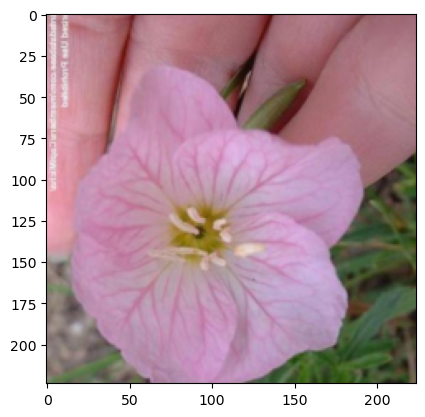

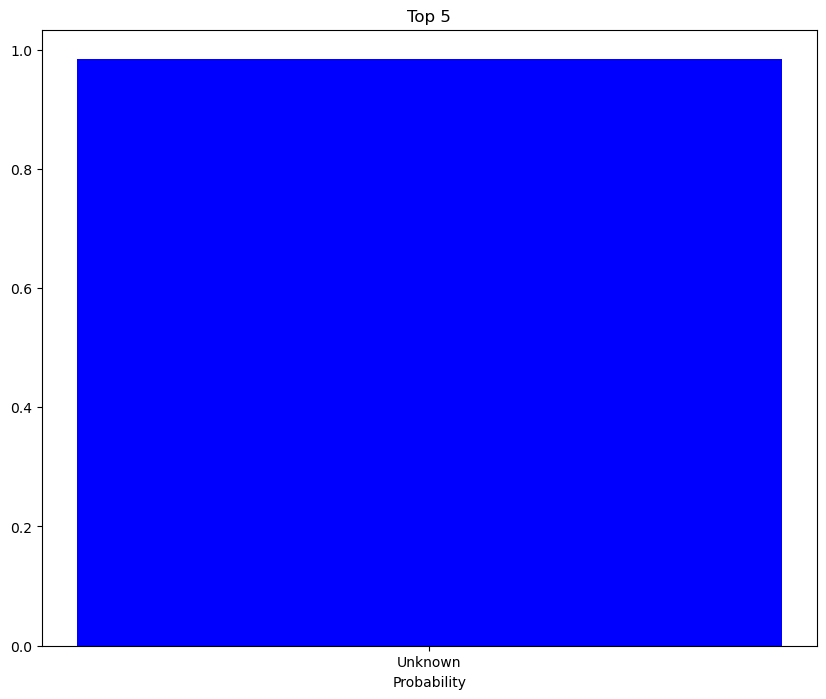

In [34]:
# TODO: Display an image along with the top 5 classes
imshow(torch.tensor(process_image(test_dir+"/1/image_06754.jpg")), title = "Prediction")
class_names = [cat_to_name.get(clas, "Unknown") for clas in classes]

plt.figure(figsize=(10,8))
plt.bar(class_names, probs, color= 'blue')
plt.xlabel("Probability")
plt.title("Top 5")
plt.show()